In [326]:
import pandas as pd


In [327]:
# site: https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation

# 1st 3 cols = B,G,R
# 4th col = skin or no skin

In [328]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'

c=pd.read_csv(url, sep = '\s+')


In [329]:
c = pd.DataFrame(c)

In [330]:
c.head()

,74,85,123,1
0,73,84,122,1
1,72,83,121,1
2,70,81,119,1
3,70,81,119,1
4,69,80,118,1


In [331]:
c.dtypes

74     int64
85     int64
123    int64
1      int64
dtype: object

In [332]:
# shifting column headers into row 
c.loc[-1] = [74, 85, 123, 1]
c.index = c.index + 1
c = c.sort_index()

In [333]:
c = c.rename(columns = {'74':'B', '85': 'G', '123': 'R', '1': 'Skin or No-Skin'})


In [334]:
c.tail()

,B,G,R,Skin or No-Skin
245052,163,162,112,2
245053,163,162,112,2
245054,163,162,112,2
245055,163,162,112,2
245056,255,255,255,2


In [335]:
y = pd.get_dummies(c['Skin or No-Skin']).iloc[:,1].dropna()


In [336]:
y = y.astype('int64')

In [337]:
y.dtypes

dtype('int64')

In [338]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: 2, dtype: int64

In [339]:
X = c.iloc[:,:-1].dropna()

In [340]:
X.head()

,B,G,R
0,74,85,123
1,73,84,122
2,72,83,121
3,70,81,119
4,70,81,119


In [341]:
X.dtypes

B    int64
G    int64
R    int64
dtype: object

In [342]:
# normalizing values because they're on different scales
# normalizing gets them on a 0 to 1 scale
# using min-max normalization

X = X.fillna(value=0) #Fill null values
for col in X.columns:
    X[col] = (X[col]-min(X[col]))/ (max(X[col]) - min(X[col])) #We subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature

X.head()

,B,G,R
0,0.290196,0.333333,0.482353
1,0.286275,0.329412,0.478431
2,0.282353,0.325490,0.474510
3,0.274510,0.317647,0.466667
4,0.274510,0.317647,0.466667


In [343]:
# split my data into test and train datasets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [344]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train, y_train)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [345]:
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [346]:
# predicting 

y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [347]:
y_hat_test.shape # (61265,)
y_hat_train.shape # (183792,)

X_train.shape # (183792, 3)
X_test.shape # (61265, 3)
y_train.shape # (183792, 1)
y_test.shape # (61265, 1)

(61265,)

In [348]:
# seeing how well our model predicted 0s and 1s

import numpy as np

#We could subtract the two columns. If values or equal, difference will be zero. Then count number of zeros.
residuals = np.abs(y_train - y_hat_train)

print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    166676
1     17116
Name: 2, dtype: int64
0    0.906873
1    0.093127
Name: 2, dtype: float64


In [349]:
# so, we can see that we got a 91% no-skin value and a 9% skin value
# this means that there's a class imbalance here with the no-skins way outnumbering the skins

In [350]:
from sklearn.metrics import roc_curve, auc


# creating ROC curve of initial model

y_score = logreg.fit(X_train, y_train).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.9324586452933378


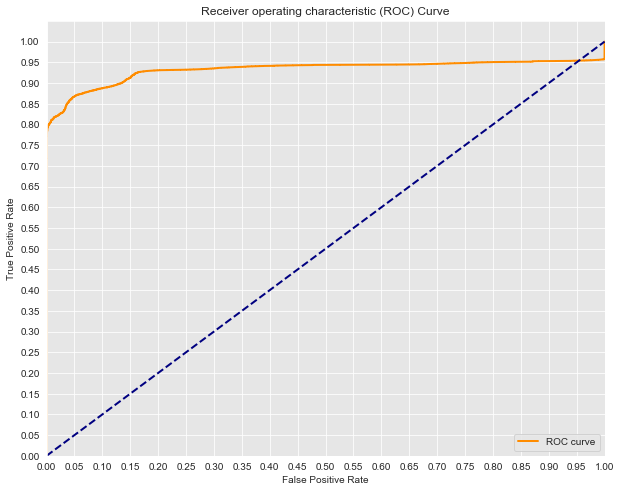

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotting ROC curve

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# AUC is 93

In [ ]:
# without class imbalance, our ROC is 93% which is pretty great!

Confusion matrix, without normalization
[[10712  3759]
 [ 2021 44773]]


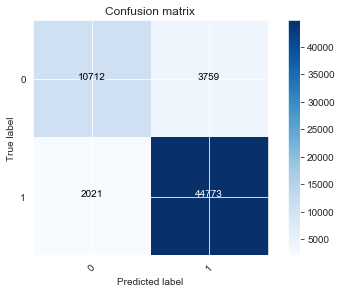

In [354]:
# plot confusion matrix w/class imbalance still in tact

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [355]:
# use SMOTE to get rid of class imbalance

from imblearn.over_sampling import SMOTE, ADASYN

X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution

1    145666
0    145666
dtype: int64


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.005, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.005: 0.9431195841744289


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.1: 0.9429287410938358


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.2: 0.942917834202947


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.5: 0.9429126170195306


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 0.8: 0.9429103725302631


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 1: 0.9429097834934258


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.25, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 1.25: 0.9429097656928621


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 1.5: 0.9429100488836493


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/flatironschool/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC for 2: 0.942909485738541


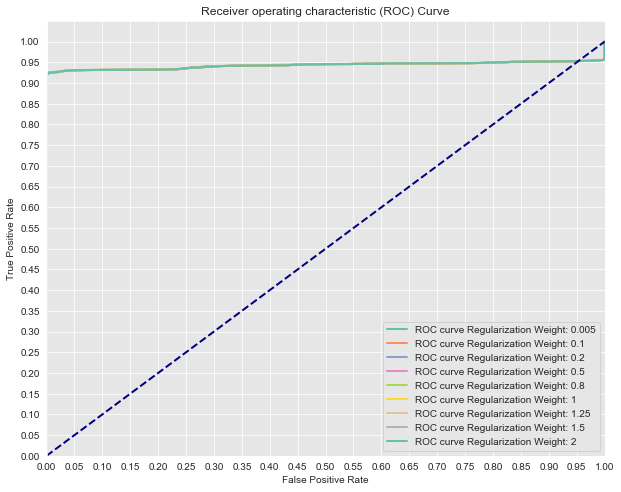

In [356]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# AUC is 94 now!

Confusion matrix, without normalization
[[12730  4276]
 [    3 44256]]


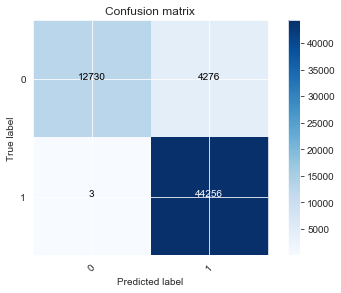

In [357]:
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])